In [105]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib notebook
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

from gensim.models import Word2Vec
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from sklearn.manifold import TSNE
from numpy import dot
from numpy.linalg import norm

from gensim.models.phrases import Phrases, Phraser
from sklearn.decomposition import PCA

In [106]:
df = pd.read_csv('Liter_1.csv')
df.head()

,Title,Theme,Citation,Year,Class,Nodes,Edges,Clusters
0,Initial impact of the COVID-19 pandemic on phy...,Accelerometer based Physical Activity,17,2020,Sensor Driven,60,20,3
1,The detrimental effect of COVID‐19 nationwide ...,Accelerometer based Physical Activity,15,2020,Data Driven,79,11,2
2,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive
3,BMW,1 Series,2011,premium unleaded (required),300,6,MANUAL,rear wheel drive
4,BMW,1 Series,2011,premium unleaded (required),230,6,MANUAL,rear wheel drive


In [107]:
df['Theme Class']= df['Class']+ " " + df['Theme']

In [108]:
# Select features from original dataset to form a new dataframe 
df1 = df[['Citation','Year', 'Nodes', 'Edges', 'Clusters','Theme Class']]
# For each row, combine all the columns into one column
df2 = df1.apply(lambda x: ','.join(x.astype(str)), axis=1) 
# Store them in the pandas dataframe
df_clean = pd.DataFrame({'clean': df2}) 
# Create the list of list format of the custom corpus for gensim modeling 
sent = [row.split(',') for row in df_clean['clean']]
# show the example of list of list format of the custom corpus for gensim modeling 
sent[:2]


[['17',
  '2020',
  '60',
  '20',
  '3',
  'Sensor Driven Accelerometer based Physical Activity'],
 ['15',
  '2020',
  '79',
  '11',
  '2',
  'Data Driven Accelerometer based Physical Activity']]

In [109]:
## Train the genisim word2vec model with our own custom corpus
model = Word2Vec(sent, min_count=1,workers=3, window =5, sg = 1)

INFO - 17:45:03: collecting all words and their counts
INFO - 17:45:03: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 17:45:03: collected 18 word types from a corpus of 36 raw words and 6 sentences
INFO - 17:45:03: Creating a fresh vocabulary
INFO - 17:45:03: Word2Vec lifecycle event {'msg': 'effective_min_count=1 retains 18 unique words (100.0%% of original 18, drops 0)', 'datetime': '2021-08-16T17:45:03.826642', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 17:45:03: Word2Vec lifecycle event {'msg': 'effective_min_count=1 leaves 36 word corpus (100.0%% of original 36, drops 0)', 'datetime': '2021-08-16T17:45:03.827639', 'gensim': '4.0.1', 'python': '3.8.8 (default, Apr 13 2021, 15:08:03) [MSC v.1916 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO - 17:45:03: deleting the raw counts dictionar

In [110]:
## We can obtain the word embedding directly from the training model
model.wv['Sensor Driven Accelerometer based Physical Activity']

array([-0.00957855,  0.00894311,  0.00416507,  0.00923473,  0.0066435 ,
        0.00292474,  0.00980402, -0.00442464, -0.00680331,  0.00422738,
        0.003729  , -0.00566461,  0.00970476, -0.00355831,  0.00954941,
        0.00083472, -0.00633846, -0.00197712, -0.00737705, -0.00297952,
        0.0010417 ,  0.00948269,  0.00935585, -0.00659588,  0.00347515,
        0.00227557, -0.00248935, -0.00922917,  0.00102713, -0.00816571,
        0.00632019, -0.00580008,  0.00553544,  0.00983372, -0.00016   ,
        0.00452849, -0.0018094 ,  0.00736076,  0.0039401 , -0.00901032,
       -0.00239851,  0.00362877, -0.00009957, -0.00120127, -0.00105544,
       -0.0016716 ,  0.00060495,  0.00416509, -0.00425279, -0.00383362,
       -0.00005282,  0.00026936, -0.00016881, -0.00478551,  0.0043134 ,
       -0.00217192,  0.00210354,  0.00066652,  0.00596968, -0.00684238,
       -0.00681571, -0.00447626,  0.00943583, -0.00159188, -0.00942924,
       -0.00054504, -0.00444892,  0.00600008, -0.00958369,  0.00

In [111]:
model.wv.similarity('Sensor Driven Accelerometer based Physical Activity', '11')

-0.04044134

In [112]:
def cosine_distance (model, word,target_list , num) :
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = dot(a, b)/(norm(a)*norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in Descedning order 
    for item in dist_sort:
        word_list.append((item[0], item[1]))
    return word_list[0:num]

In [113]:
cosine_distance (model,'Mercedes-Benz SLK-Class',model,5) 

TypeError: 'Word2Vec' object is not subscriptable

In [114]:
def display_closestwords_tsnescatterplot(model, word, size):
    
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]

    close_words = model.wv.similar_by_word(word)

    arr = np.append(arr, np.array([model.wv[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model.wv[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.show()

<IPython.core.display.Javascript object>


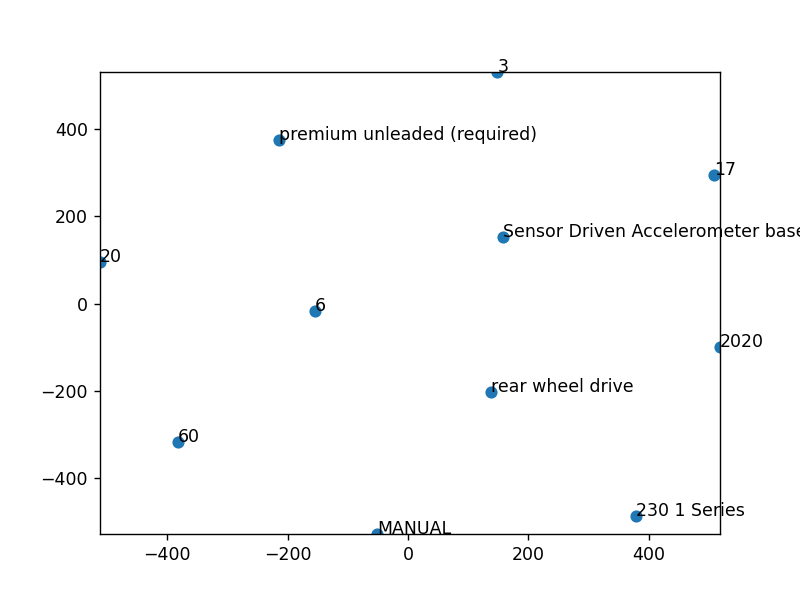

In [115]:
display_closestwords_tsnescatterplot(model, 'Sensor Driven Accelerometer based Physical Activity', 100)

In [91]:
close_words = model.wv.similar_by_word('Sensor Driven Accelerometer based Physical Activity')
print(close_words)

[('2', 0.14595064520835876), ('17', 0.050482068210840225), ('11', 0.041577357798814774), ('79', 0.03476494178175926), ('15', 0.01915230229496956), ('2020', 0.01613471284508705), ('20', 0.008826175704598427), ('3', 0.004842518828809261), ('60', 0.0019511713180691004), ('Data Driven Accelerometer based Physical Activity', -0.11410725116729736)]


In [76]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 100), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))

In [74]:
tsnescatterplot(model, 'Sensor Driven Accelerometer based Physical Activity', [])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 300 and the array at index 1 has size 100